In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tools.plot.im import imshow_all
from tools.gaussian.gen import generate, TruncGaussParams
from tools.gaussian.SpotVector import GaussSpot
from linking.gauss_linking import TrackGausses

## Synthetic data generation
Define functions:
- `gen` for random spots generations, 
- `variate` for variation and 
- `variation_transition_matrix` for calculating expected transition matrix, corresponding to a given variation

In [23]:
SIZE = 64 # image size
N_SPOTS = SIZE*SIZE // 250 # approx 1/density

# TODO: use real data for tracking accuracy evaluation

def gen(n=N_SPOTS, image_size=SIZE):
    return generate(
        image_size=image_size, 
        n_spots=n, 
        sig=TruncGaussParams(range=(0.6, 2.), mu=0.65, sig=0.7),
        intensity=TruncGaussParams(range=(0,20.), mu=1., sig=1.),
    )


# TODO: many-to-one/one-to-many transitions
def variate(x: GaussSpot, new_spots=0, disapp_spots=0, std = 1):
    x_tensor = x.tensor
    if disapp_spots > 0:
        x_tensor = x_tensor[:-disapp_spots]
    y = GaussSpot(x_tensor.clone())
    y.mu += torch.randn(y.mu.shape) * std
    #y.intensity += torch.randn(n_spots)

    if new_spots > 0:
        y = GaussSpot(
            torch.cat((y.tensor,  gen(new_spots).tensor))
        )
    return y


def variation_transition_matrix(x: GaussSpot, y: GaussSpot, new_spots=0):
    '''
        variation_transition_matrix matrix:
        0-raw/column in transition matrix corresponds to spots appearing/disappearing
    '''
    disapp_spots = len(x) - (len(y) - new_spots)
    assert new_spots >= 0
    assert disapp_spots >= 0
    expected_transition = torch.zeros(len(x) + 1, len(y) + 1)
    for i in range(len(x) - disapp_spots):
        expected_transition[i+1,i+1] = x[i].intensity
    for i in range(disapp_spots):
        j = len(x) - disapp_spots + i
        expected_transition[j+1,0] = x[j].intensity
    for i in range(new_spots):
        j = len(y) - new_spots + i
        expected_transition[0, j+1] = y[j].intensity
    return expected_transition


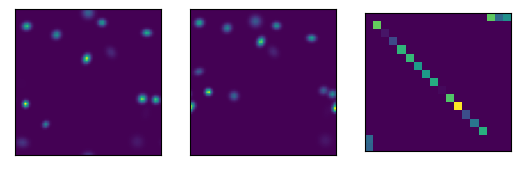

In [27]:
# visualised example
x = gen()
y = variate(x, 3, 2, std=5)

tx_mx = variation_transition_matrix(x, y, 3)
imshow_all(x.sum_image(SIZE), y.sum_image(SIZE), tx_mx)

In [16]:
# def calculate_accuracy():
    # i_err = torch.abs(torch.diag(result)[1:-n_disapp_spots] - x.intensity[:-n_disapp_spots]).sum() + \
    #     torch.abs(x.intensity[-n_new_spots:] - result[-n_new_spots:,0]).sum() + \
    #     torch.abs(y.intensity[-n_new_spots:] - result[0:,-n_new_spots:]).sum()
    
    # max_idx = torch.max(result, dim=0)[1]
    # n_correct = ( (max_idx[1:-n_disapp_spots] - torch.range(1, len(x.tensor)-n_disapp_spots)) == 0).sum()
    # n_correct += (max_idx[-n_new_spots:] == 0).sum()     
    # acc += n_correct / len(x.tensor)
            
    # err += i_err / x.intensity.sum()

## Evaluation Metrics of the method
 Calculating loss for a certain `max_dist` on a range of `std` parameter related to the coordinate variations (which denotes the amount of average spot shift)

In [5]:
def calculate_metrics(
    max_dist = 100.,
    std_range = range(1, 11),
    k=20, # avreraging number
):
    loss_list = []
    for std in std_range:
        loss = 0
        for _ in range(k):
            x = gen()
            n_new_spots = 3
            n_disapp_spots = 2
            y = variate(x, new_spots=n_new_spots, disapp_spots=n_disapp_spots, std=std)
            expected_transition = variation_transition_matrix(x, y, n_new_spots)
            

            tracker = TrackGausses(x, y, max_dist=max_dist)
            tracker.calc_distance()
            transition_matrix = tracker.optimize()

            loss += F.mse_loss(transition_matrix, expected_transition).item()
            #TODO: discrete accuracy
            
        loss_list.append(loss/k)
    return loss_list


In [9]:
loss_list = calculate_metrics()
metrics = {}

DIST_VALUES = [ 5, 7, 10, 11 ]
for d in DIST_VALUES:
    metrics[d] = calculate_metrics(d)


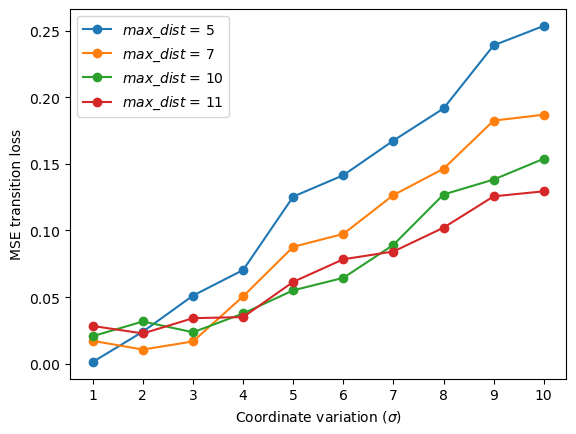

In [15]:
for k, v in metrics.items():
    plt.plot(range(1, 11), v, label="$max\_dist$ = " + str(k), marker='o')

plt.ylabel("MSE transition loss")
plt.xlabel("Coordinate variation ($\sigma$)")
plt.xticks(range(1, 11))
plt.legend()
plt.show()